In [1]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy

import os
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune

from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle, Aggregator
from src.algorithms.rl import EnergyCommunityMultiHouseholdsEnv_v0

In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define resources

resources = []

# Add the aggregator, prices are shared across households
aggregator = Aggregator(name='aggregator_1',
                        imports=np.zeros(data.peers['buy_price'][0].shape),
                        exports=np.zeros(data.peers['buy_price'][0].shape),
                        import_max=data.peers['import_contracted_p_max'][0],
                        export_max=data.peers['export_contracted_p_max'][0],
                        import_cost=data.peers['buy_price'][0],
                        export_cost=data.peers['sell_price'][0]
                        )

max_timesteps = aggregator.imports.shape[0]
# Generate the households
# For simplicity, we assume there are as many households as there are loads
for i in range(data.load['p_forecast'].shape[0]):
    household_resources = {}
    # Add the loads
    household_resources['load']=Load(name='load_{:02d}'.format(i + 1),
                                    value=data.load['p_forecast'][i],
                                    cost_cut=data.load['cost_cut'][i],
                                    cost_reduce=data.load['cost_reduce'][i],
                                    cost_ens=data.load['cost_ens'][i])

    # Add the generators
    household_resources['generator'] = Generator(name='generator_{:02d}'.format(i + 1),
                                         value=np.zeros(data.generator['p_forecast'][0].shape),
                                         lower_bound=np.zeros(data.generator['p_forecast'].shape),
                                         upper_bound=data.generator['p_forecast'][i],
                                         cost=data.generator['cost_parameter_b'][i],
                                         cost_nde=data.generator['cost_nde'][i],
                                         is_renewable=data.generator['type_generator'][i])

    # Add the storage
    if i < data.storage['p_charge_limit'].shape[0]:
        household_resources['storage']=(Storage(name='storage_{:02d}'.format(i + 1),
                                           value=np.zeros(data.storage['p_charge_limit'][0].shape),
                                           cost_discharge=data.storage['discharge_price'][i],
                                           cost_charge=data.storage['charge_price'][i],
                                           capacity_max=data.storage['energy_capacity'][i],
                                           capacity_min=0,
                                           initial_charge=data.storage['initial_state'][i],
                                           discharge_efficiency=data.storage['discharge_efficiency'][i],
                                           charge_efficiency=data.storage['charge_efficiency'][i],
                                           discharge_max=data.storage['p_discharge_max'][i],
                                           charge_max=data.storage['p_charge_max'][i],
                                           capital_cost=0))

    household_resources['aggregator'] = deepcopy(aggregator)
    resources.append(household_resources)


In [4]:
# Create the environment and check if everything is ok
import_penalty = 5000
export_penalty = 5000
storage_action_reward = 0
storage_action_penalty = 5000
balance_penalty = 0
# TODO: Take costs from the excel file
temp_env = EnergyCommunityMultiHouseholdsEnv_v0(households_resources=resources, import_penalty=import_penalty,
                                                export_penalty=export_penalty,
                                                storage_action_penalty=storage_action_penalty,
                                                storage_action_reward=storage_action_reward,
                                                balance_penalty=balance_penalty,
                                                max_timesteps=max_timesteps)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.households}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Reward: {0: -25045074.884638183, 1: -25005534.62502359, 2: -105519.20565266926, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -20573.59504699707, 1: -263396.15521240234, 2: -25085908.286322914, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -13827.375411987305, 1: -152774.4892578125, 2: 0.4, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -43155.81021118164, 1: -1.5674072189331054, 2: -7188.524425252278, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -46854.3701171875, 1: 1.2, 2: -105215.7531015625, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -21972.144874074096, 1: 1.777087926864624, 2: -62928.623921712235, 3: 0.0036266519703681216, 4: 0.0029505505736339074, 5: 0.04837225087356568}
Reward: {0: -19953.880553964118, 1: -22807.976247644423, 2: -0.0, 3: 0.020263213161274024, 4: 0.012377600440466931, 5: 0.11330805088925361}
Reward: {0: -25008627.902868845, 1: -20005.138397216797, 2: -0.0, 3: 0.04309222146623091, 4: 0.019724851844838867, 5: 0.08694582289928197}
Reward: {0: -29626.96559101986, 1: 1.2, 2: -35916.21398925781, 3: 

In [5]:
print(temp_env.final_logs)

{'total_imported_energy': [22.0, 50.0, 60.0, 65.0, 30.0, 70.80609681477267, 6.236872030580454, 3.7440724052587937, 40.69678788460806, 64.5105313237751, 66.55481764985889, 42.304330557257416, 26.47636152409992, 70.73863025500684, 58.99359100190318, 11.534416872806474, 19.699107068950685, 110.89457804396382, 0.5284122341060619, 5.108251571655273, 100.0, 45.4100227355957, 10.0, 73.5887336730957], 'total_exported_energy': [22.0, 50.0, 60.0, 65.0, 30.0, 70.80609681477267, 6.236872030580454, 3.7440724052587937, 40.69678788460806, 64.5105313237751, 66.55481764985889, 42.304330557257416, 26.47636152409992, 70.73863025500684, 58.99359100190318, 11.534416872806474, 19.699107068950685, 110.89457804396382, 0.5284122341060619, 5.108251571655273, 100.0, 45.4100227355957, 10.0, 73.5887336730957], 'total_soc': [2.0, 2.0, 2.0, 0.8621082305908203, 1.8621082305908203, 0.7178362488746644, 1.0, 2.0, 2.0, 1.3190182209014893, 1.8140966653823853, 1.8140966653823853, 2.0376615047454836, 2.0, 1.0, 2.70518274307

In [6]:
# Aux function to assign policies

def assign_policies(env):
    policies = {}
    for household_id in env.households:
        policies[str(household_id)] = (None,
                           env.observation_space[household_id],
                           env.action_space[household_id],
                           {})
    return policies


policies = assign_policies(env=temp_env)

In [7]:
from ray.tune import register_env

# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

ray.shutdown()
ray.init()
run_env = EnergyCommunityMultiHouseholdsEnv_v0(households_resources=resources,
                                                                             import_penalty=import_penalty,
                                                                             export_penalty=export_penalty,
                                                                             storage_action_penalty=storage_action_penalty,
                                                                             storage_action_reward=storage_action_reward,
                                                                             balance_penalty=balance_penalty,
                                                                             max_timesteps=max_timesteps)
register_env("EC_Multi", lambda config: run_env)

config = (
    PPOConfig()
    .environment(env="EC_Multi")
    .training(
        train_batch_size=240,
        lr=2e-4,
        gamma=0.99)
    # entropy_coeff=0.05,
    # kl_coeff=0.0)
    .framework('torch')  # 'tf2', eager_tracing=False)
    .rollouts(num_rollout_workers=10, rollout_fragment_length=24)
    .multi_agent(policies=policies,
                 policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: str(agent_id))
)
# Use the config's `build()` method to construct a PPO object.
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
# Since we have to guess 10 times and the optimal reward is 0.0
# (exact match between observation and action value),
# we can expect to reach an optimal episode reward of 0.0.
checkpoint = None
for i in range(20):
    results = algo.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    if results['episode_reward_mean'] > -50.0:
        break

    # Save the checkpoint to disk.
    checkpoint = algo.save()
    # print("checkpoints saved at", checkpoint)

2024-05-28 16:28:10,010	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-28 16:28:11,816	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-05-28 16:28:11,818	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.env_runners(num_rollout_workers)` has been deprecated. Use `AlgorithmConfig.env_runners(num_env_runners)` instead. This will raise an error in the future!
2024-05-28 16:28:11,823	WARNING deprecation.py:50 -- DeprecationWarning: `num_envs_per_worker` has been deprecated. Use `AlgorithmConfig.num_envs_per_env_runner` instead. This will raise an error in the future!
C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\algorithms\algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::Deprecation

Iter: 0; avg. reward=nan
Iter: 1; avg. reward=-180641429.02102965
Iter: 2; avg. reward=-159699032.8151707
Iter: 3; avg. reward=-150028948.42928228
Iter: 4; avg. reward=-135901309.16925496
Iter: 5; avg. reward=-120807478.10358898
Iter: 6; avg. reward=-108268208.86409162
Iter: 7; avg. reward=-101744101.04477163
Iter: 8; avg. reward=-94640063.72561975
Iter: 9; avg. reward=-86874742.81482011
Iter: 10; avg. reward=-81156752.96342862
Iter: 11; avg. reward=-65098439.849800564
Iter: 12; avg. reward=-52444860.71391076
Iter: 13; avg. reward=-40801212.85691849
Iter: 14; avg. reward=-32672217.229388572
Iter: 15; avg. reward=-27320216.58346306
Iter: 16; avg. reward=-23659290.548297748
Iter: 17; avg. reward=-18022476.161921676
Iter: 18; avg. reward=-13843580.052929094
Iter: 19; avg. reward=-11972183.522931473


In [8]:
algo.evaluation_metrics

{'evaluation': {'episode_reward_max': nan,
  'episode_reward_min': nan,
  'episode_reward_mean': nan,
  'sampler_results': {'episode_reward_max': nan,
   'episode_reward_min': nan,
   'episode_reward_mean': nan}}}

In [9]:
algo.get_state()

{'iteration': 20,
 'timesteps_total': None,
 'time_total': 71.17653465270996,
 'episodes_total': 190,
 'last_result': {'custom_metrics': {},
  'episode_media': {},
  'info': {'learner': {'2': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 1.6072334080934525,
      'cur_kl_coeff': 0.7593750000000001,
      'cur_lr': 0.00020000000000000006,
      'total_loss': 6.859228324890137,
      'policy_loss': -0.03356546958287557,
      'vf_loss': 6.883545589447022,
      'vf_explained_var': -2.22325325012207e-06,
      'kl': 0.012178834398218897,
      'entropy': 2.0924310167630513,
      'entropy_coeff': 0.0},
     'model': {},
     'custom_metrics': {},
     'num_agent_steps_trained': 120.0,
     'num_grad_updates_lifetime': 1170.5,
     'diff_num_grad_updates_vs_sampler_policy': 29.5},
    '4': {'learner_stats': {'allreduce_latency': 0.0,
      'grad_gnorm': 1.7638625343640646,
      'cur_kl_coeff': 1.0125000000000004,
      'cur_lr': 0.00020000000000000006,
      'total_loss

In [ ]:
algo.

In [ ]:
# Check the actions (inference)

temp_env = EnergyCommunityMultiEnv_v0(resources)
obs, info = temp_env.reset()
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
episode_info = []
while not terminations['__all__'] and not truncations['__all__']:
    print('Timestep: {}'.format(temp_env.current_timestep))
    action_dict = {a: algo.compute_single_action(observation=obs[a], policy_id=a) for a in temp_env.agents}
    #action_dict = {'producer': algo.compute_single_action(observation=obs['producer'], policy_id='pol_producer'),
    #               'consumer': algo.compute_single_action(observation=obs['consumer'], policy_id='pol_consumer')}
    obs, reward, terminations, truncations, info = temp_env.step(action_dict)
    episode_info.append(info)
    #total_reward_prod += reward['producer']
    #total_reward_cons += reward['consumer']
    #print(f"Producer Action: {action_dict['producer']}; reward: {reward['producer']}; total reward: {total_reward_prod}")
    #print(f"Consumer Action: {action_dict['consumer']}; reward: {reward['consumer']}; total reward: {total_reward_cons}")

In [ ]:
episode_info

[]

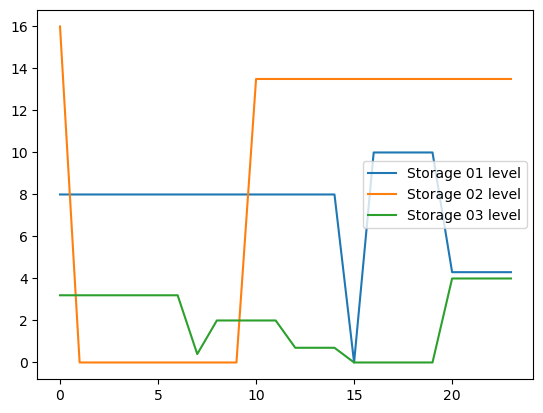

In [13]:
# Plot the storage

for s in range(1, 4):
    temp_storage = [episode_info[i]['storage_{:02d}'.format(s)]['current']
                    for i in range(len(episode_info) - 1)]
    plt.plot(temp_storage,
             label='Storage {:02d} level'.format(s))

plt.legend()
plt.plot()

[]

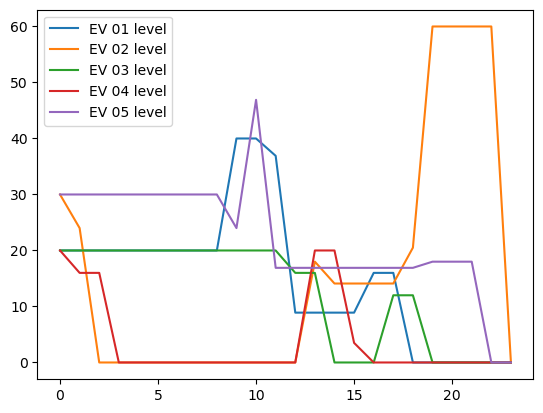

In [14]:
# Plot the EVs

for e in range(1, 6):
    temp_ev = [episode_info[i]['ev_{:02d}'.format(e)]['current']
               for i in range(len(episode_info) - 1)]
    plt.plot(temp_ev,
             label='EV {:02d} level'.format(e))

plt.legend()
plt.plot()

In [15]:
import torch

torch.device('cuda')

device(type='cuda')

In [19]:
torch.cuda.is_available()

False

In [17]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [18]:
import torch

print("Torch version:", torch.__version__)

print("Is CUDA enabled?", torch.cuda.is_available())

Torch version: 2.2.2+cpu
Is CUDA enabled? False
